In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
if os.getenv("OPENAI_API_KEY"):
    print("Cargado correctamente API")

Cargado correctamente API


In [2]:
from langchain_openai import ChatOpenAI

MODEL = "gpt-4o-mini"
llm = ChatOpenAI(model=MODEL,temperature=0.4)

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MyState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]
    intencion: str
    summary: str

In [71]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def identificar_intencion(state: MyState) -> dict:
    system_promp = """Tu tarea es identificar y clasificar la intención del usuario a partir de la conversación proporcionada, usando la siguiente lista de posibles intenciones:

    agendar_cita: El usuario desea reservar o programar una nueva cita.
    consultar_cita: El usuario quiere obtener información sobre una cita ya existente, como la hora o el lugar.
    reagendar_cita: El usuario busca cambiar la fecha o la hora de una cita previamente programada.
    otra: cuando el usuario realiza una conversacion fuera del contexto

    Debes responder solamente con una intención de esta lista: [agendar_cita, consultar_cita, reagendar_cita, otra]
    No agregues mas palabras
    """
    resp = llm.invoke([SystemMessage(content=system_promp)] + state["messages"])
    intencion = resp.content.strip().lower()
    # print(resp)
    return {"messages": state.get("messages","") + [f"intencion identificada: {intencion}"], "intencion": intencion, "summary": state.get("summary","") + f"Intención detectada: {intencion}"}

In [82]:
def consultar_cita(state: MyState) -> dict:
    system_prompt = """Eres una base de datos que tienes agendado citas, cuado el usuario te pida una consulta de cita tu vas a responder con la fecha y la hora de forma simulada.    
    """

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    cita = resp.content
    return {"messages": state["messages"] + [f"{cita}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {cita}"
            }

In [81]:
def agendar_cita(state: MyState) -> dict:
    system_prompt = """Eres un asistsente útil que agendas citas, cuando el uasuario te pase la fecha y la hora vas a responder como que ya estubiera agendad la cita.     
    """

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    agenda = resp.content
    return {"messages": state["messages"] + [f"{agenda}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {agenda}"
    }

In [77]:
def otra(state: MyState) -> dict:
    system_prompt = """Eres un asistsente útil, sigue la conversacion del usuario de forma natural   
    """

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    agenda = resp.content
    return {"messages": state["messages"] + [f"{agenda}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {agenda}"
    }

In [74]:
#funcion determinar ruta
def determinar_ruta(state: MyState) -> str:
    intencion = state['intencion']
    if intencion == "consultar_cita":
        return "consultar_cita"
    elif intencion == "agendar_cita":
        return "agendar_cita"
    else: 
        intencion == "otra"
        return "otra"


In [87]:
import sqlite3

db_path="state_db/exmple.db"
conn=sqlite3.connect(db_path,check_same_thread = False)

In [88]:
#checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

In [89]:
from langgraph.graph import StateGraph, START, END

#Define Grafo
builder = StateGraph(MyState)

#Define nodos
builder.add_node('identificar_intencion',identificar_intencion)
builder.add_node('consultar_cita',consultar_cita)
builder.add_node('agendar_cita',agendar_cita)
builder.add_node('otra',otra)

#Define la secuencia de los agentes para este caso 
builder.add_edge(START,'identificar_intencion')
builder.add_conditional_edges("identificar_intencion",determinar_ruta, {
        "consultar_cita": "consultar_cita",
        "agendar_cita": "agendar_cita",
        "otra": 'otra'
    })
builder.add_edge('consultar_cita',END)
builder.add_edge('agendar_cita',END)
builder.add_edge('otra',END)

#Tambien para definir la secuencia se debe utilizar:
# graph.add_conditional_edges()

#compilar
graph = builder.compile(checkpointer=memory)

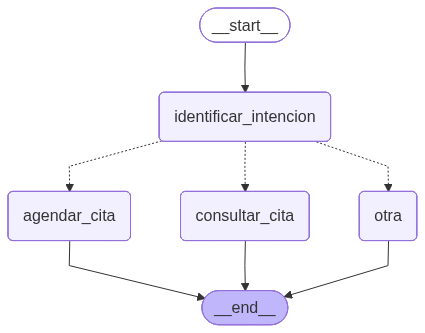

In [84]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id":"2"}}

In [93]:
content = "Para mañana a las 2 pm"
messages = [HumanMessage(content=content)]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

hola soy Jefferson
================================== Ai Message ==================================

¡Hola, Jefferson! ¿Cómo estás? ¿Hay algo en particular de lo que te gustaría hablar?
================================ Human Message =================================

Cual era mi nombre ?
================================== Ai Message ==================================

Tu nombre es Jefferson. ¿Te gustaría hablar sobre algo en particular?
================================ Human Message =================================

me gusta viajar
================================== Ai Message ==================================

¡Genial! Viajar es una experiencia maravillosa. ¿Tienes algún destino favorito o algún lugar al que te gustaría ir en el futuro?
================================ Human Message =================================

a que hora me dijiste la cita que tenia ?
================================ Human Messa

In [33]:
if __name__ == "__main__":

    state = {
        "messages": [HumanMessage(content="consultar_cita")],
        "summary": ""
    }
    
    result = consultar_cita(state)
    print(result)




None


In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph()